# 使用データ

使用データUnsupervised Detection of Anomalous Sounds for Machine Condition Monitoring  
URL: http://dcase.community/challenge2020/task-unsupervised-detection-of-anomalous-sounds  
Dataset: https://zenodo.org/record/3678171#.XnNfOpP7SL4

DCASE 2020 Task 2 Unsupervised Detection of Anomalous Sounds for Machine Condition Monitoring」(機械の状態監視のための教師なし異常音検知)のデータを用いてCNNのモデルを動かしてみます。
データはDepelopmentDataset内にあるpumpの正常データと異常データを用います。

# 環境構築

Anaconda上に[keras_tutorial]の名前にて仮想環境を作成、次のパッケージをインストール

conda install -y numpy  
conda install -y pandas  
conda install -y tensorflow==1.14.0  
conda install -y keras==2.3.1  
conda install -c conda-forge -y librosa==0.7.2  
conda install -y numba==0.45.0

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import sklearn
import IPython
import glob
import keras

Using TensorFlow backend.
C:\Users\user\anaconda3\envs\keras_tutorial\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\anaconda3\envs\keras_tutorial\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\anaconda3\envs\keras_tutorial\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\anaconda3

In [2]:
pump_train_file = glob.glob('Development_dataset/pump/train/*.wav')
pump_test_file = glob.glob('Development_dataset/pump/test/*.wav')

print("train_data:" + str(len(pump_train_file)))
print("test_data:" + str(len(pump_test_file)))

train_data:3349
test_data:856


### 正常音を聞いてみる

In [3]:
wav, sr = librosa.load(pump_train_file[0], sr=None)
IPython.display.Audio(data = wav,rate = sr)

### 異常音を聞いてみる

In [4]:
wav, sr = librosa.load(pump_test_file[0], sr=None)
IPython.display.Audio(data = wav,rate = sr)

In [5]:
np.r_[pump_train_file, pump_test_file]
np.r_[np.zeros(len(pump_train_file)), np.ones(len(pump_test_file))]

array([0., 0., 0., ..., 1., 1., 1.])

In [6]:
x = np.r_[pump_train_file, pump_test_file]
y = np.r_[np.zeros(len(pump_train_file)), np.ones(len(pump_test_file))]
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.25, stratify=y,random_state = 0)
print("x_train:{0}\ny_train:{1}\nx_test:{2}\ny_test:{3}".format(len(x_train),len(y_train),len(x_test),len(y_test)))

x_train:3153
y_train:3153
x_test:1052
y_test:1052


In [7]:
x = []
for f in x_train:
    wav, sr = librosa.load(f, sr=None)
    stft = librosa.stft(wav)
    l_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=l_stft,sr=sr)
    x.append(melsp)
x_train = np.array(x)[:,:,:,np.newaxis]
x = []
for f in x_test:
    wav, sr = librosa.load(f, sr=None)
    stft = librosa.stft(wav)
    l_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=l_stft,sr=sr)
    x.append(melsp)
x_test = np.array(x)[:,:,:,np.newaxis]

C:\Users\user\anaconda3\envs\keras_tutorial\lib\site-packages\librosa\core\spectrum.py:888: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  warnings.warn('power_to_db was called on complex input so phase '


In [8]:
print("x_train.shape:"+str(x_train.shape))
print("x_test.shape:"+str(x_test.shape))

x_train.shape:(3153, 128, 313, 1)
x_test.shape:(1052, 128, 313, 1)


### 正常音のメルスペクトログラム

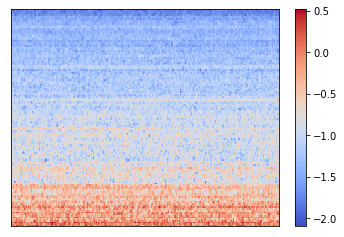

In [9]:
librosa.display.specshow(x_train[0].reshape((x_train.shape[1],x_train.shape[2])), sr=sr)
plt.colorbar()
plt.show()

### 異常音のメルスペクトログラム

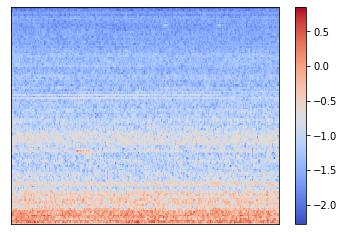

In [10]:
librosa.display.specshow(x_test[0].reshape((x_test.shape[1],x_test.shape[2])), sr=sr)
plt.colorbar()
plt.show()

In [11]:

classes = len(np.unique(y_train))
y_train_c = keras.utils.to_categorical(y_train, classes)
y_test_c = keras.utils.to_categorical(y_test, classes)

In [18]:
# define CNN
inputs = keras.layers.Input(shape=(x_train.shape[1:]))

x = keras.layers.Conv2D(filters=2, kernel_size=(1,4), strides=(1,2), padding='same')(inputs)
x = keras.layers.Conv2D(filters=2, kernel_size=(4,1), strides=(2,1), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
# x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(filters=4, kernel_size=(1,4), strides=(1,2), padding='same')(x)
x = keras.layers.Conv2D(filters=4, kernel_size=(4,1), strides=(2,1), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
# x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(filters=8, kernel_size=(1,4), strides=(1,2), padding='same')(x)
x = keras.layers.Conv2D(filters=8, kernel_size=(4,1), strides=(2,1), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
# x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(filters=16, kernel_size=(1,4), strides=(1,2), padding='same')(x)
x = keras.layers.Conv2D(filters=16, kernel_size=(4,1), strides=(2,1), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
# x = keras.layers.MaxPooling2D()(x)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(classes)(x)
x = keras.layers.Activation("softmax")(x)

model = keras.models.Model(inputs, x)

# initiate Adam optimizer
opt = keras.optimizers.adam(lr=0.00001, decay=1e-6, amsgrad=True)

# Let's train the model using Adam with amsgrad
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 313, 1)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 157, 2)       10        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 157, 2)        18        
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 157, 2)        8         
_________________________________________________________________
activation_10 (Activation)   (None, 64, 157, 2)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 79, 4)         36        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 79, 4)         68  

In [ ]:
batch_size = 32
epochs = 10
model.fit(x= x_train, y=y_train_c, batch_size = batch_size, epochs = epochs)

Epoch 1/10
3153/3153 [==============================] - 23s 7ms/step - loss: 0.5172 - accuracy: 0.7964
Epoch 2/10
3153/3153 [==============================] - 25s 8ms/step - loss: 0.5130 - accuracy: 0.7964
Epoch 3/10
3153/3153 [==============================] - 23s 7ms/step - loss: 0.5089 - accuracy: 0.7964
Epoch 4/10
3153/3153 [==============================] - 23s 7ms/step - loss: 0.5061 - accuracy: 0.7964
Epoch 5/10
3153/3153 [==============================] - 22s 7ms/step - loss: 0.5033 - accuracy: 0.7964
Epoch 6/10
3153/3153 [==============================] - 24s 7ms/step - loss: 0.5011 - accuracy: 0.7964
Epoch 7/10
3153/3153 [==============================] - 23s 7ms/step - loss: 0.4984 - accuracy: 0.7964
Epoch 8/10
3153/3153 [==============================] - 24s 8ms/step - loss: 0.4960 - accuracy: 0.7964
Epoch 9/10
 384/3153 [==>...........................] - ETA: 19s - loss: 0.4680 - accuracy: 0.8177

In [ ]:
evaluation = model.evaluate(x_test, y_test_c)
print(evaluation)

In [ ]:
pred = model.predict(x_test)
y_pred = pred.argmax(axis=1)

In [ ]:
print(sklearn.metrics.confusion_matrix(y_test, y_pred))
print('accrucy: '+ str( sklearn.metrics.accuracy_score(y_test, y_pred) ))
print('precision: '+ str( sklearn.metrics.precision_score(y_test, y_pred) ))
print('recall: '+ str( sklearn.metrics.recall_score(y_test, y_pred) ))
print('f1: '+ str( sklearn.metrics.f1_score(y_test, y_pred) ))